## Primeres proves de models

In [1]:
# Importar librerías que vamos a estar usando en general
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm, trange

## Load data

In [2]:
pth = "/Users/albam/Desktop/UNIVERSITAT/POSTGRAU/CAPSTONE_PROJECT/Gorrapiedra-proyecto/data/formated data"
info_stations = '/Users/albam/Desktop/UNIVERSITAT/POSTGRAU/CAPSTONE_PROJECT/Gorrapiedra-proyecto/data/info bicing/Informacio_Estacions_Bicing.csv'

df_20 = pd.read_csv(os.path.join(pth, "data_2020.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_21 = pd.read_csv(os.path.join(pth, "data_2021.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_22 = pd.read_csv(os.path.join(pth, "data_2022.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_23 = pd.read_csv(os.path.join(pth, "data_2023.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_info = pd.read_csv(os.path.join(info_stations), index_col=False, skipinitialspace=True, skip_blank_lines=True)

dfs_list = [df_20, df_21, df_22, df_23, df_info]

# Eliminem les estacions que no estan a tots els datasets

for proto_df in dfs_list:       # fyi: en aquest cas, totes les estacions estan a tots els datasets
    for otro_df in dfs_list:
        if proto_df is not otro_df:
            proto_df = proto_df[proto_df['station_id'].isin(otro_df['station_id'])]

df_info_stations = df_info[['station_id', 'lat', 'lon', 'post_code', 'capacity']]

df = pd.concat([df_20, df_21, df_22, df_23], ignore_index = True)
df = pd.merge(df, df_info_stations, on='station_id')

if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)   # Eliminar columna Unnamed

print("min and max value of station id: ", df['station_id'].min(), df['station_id'].max())

# Visualitzar el df
print("Shape of the df: ", df.shape)
df.head()

Shape of the df:  (3275160, 14)


,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,lat,lon,post_code,capacity
0,1.0,2020.0,1.0,1.0,2.0,0.522727,0.503788,0.469697,0.403409,0.354167,41.397978,2.180107,8013,45
1,1.0,2020.0,1.0,1.0,7.0,0.289773,0.373106,0.304924,0.238636,0.240530,41.397978,2.180107,8013,45
2,1.0,2020.0,1.0,1.0,12.0,0.253788,0.268939,0.350379,0.344697,0.393939,41.397978,2.180107,8013,45
3,1.0,2020.0,1.0,1.0,17.0,0.390152,0.346591,0.255814,0.220930,0.186047,41.397978,2.180107,8013,45
4,1.0,2020.0,1.0,1.0,22.0,0.083333,0.218992,0.437984,0.515504,0.470930,41.397978,2.180107,8013,45


In [3]:
# Ara que el dataset té més info, s'haurà de canviar el preprocessament potser. Com veieu

In [4]:
# Dividir el dataset en training i test
from sklearn.model_selection import train_test_split

y = df['percentage_docks_available']
X = df.drop(['percentage_docks_available'], axis=1)

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=30)

In [5]:
# Encoding
cat_cols = ['station_id']#, 'month', 'day', 'year']
x_train_encoded = pd.get_dummies(X_train, columns=cat_cols)
x_validation_encoded = pd.get_dummies(X_validation, columns=cat_cols)

In [6]:
# Veiem si el training set y el validation set tenen diferent número de columnes després del encoding. Mirem quines son les columnes que falten al validation set.
missing_cols = set(x_train_encoded.columns) - set(x_validation_encoded.columns)
print("Missing columns in validation set:", missing_cols)

# Si hay columnas que faltan en el validation set, las borramos del training set
for col in missing_cols:
    x_train_encoded.drop(col, axis=1, inplace=True)

print("Training set shape after deleting columns:", x_train_encoded.shape)
print("Validation set shape:", x_validation_encoded.shape)

Missing columns in validation set: set()
Training set shape after deleting columns: (2292612, 518)
Validation set shape: (982548, 518)


In [7]:
# Normalitzar les dades
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

x_train_encoded_scal = scaler.fit_transform(x_train_encoded)
x_validation_encoded_scal = scaler.fit_transform(x_validation_encoded)

print("Training set shape:", x_train_encoded_scal.shape)
print("Validation set shape:", x_validation_encoded_scal.shape)

Training set shape: (2292612, 518)
Validation set shape: (982548, 518)


In [8]:
# Decision tree

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

dtr = DecisionTreeRegressor(max_depth=7)

dtr.fit(x_train_encoded_scal, y_train)

y_pred = dtr.predict(x_validation_encoded_scal)

mse = mean_squared_error(y_validation, y_pred)
rmse = mean_squared_error(y_validation, y_pred, squared=False)
mae = mean_absolute_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)


MSE: 0.012907935236319511
RMSE: 0.11361309447559076
MAE: 0.0738620099989864
R2: 0.8412338104207583


In [9]:
#!pip install xgboost

In [10]:
from xgboost import XGBRegressor

xgbr = XGBRegressor(n_estimators=1000, learning_rate=0.01, n_jobs=4)

xgbr.fit(x_train_encoded_scal, y_train)

y_pred = xgbr.predict(x_validation_encoded_scal)

mse = mean_squared_error(y_validation, y_pred)
rmse = mean_squared_error(y_validation, y_pred, squared=False)
mae = mean_absolute_error(y_validation, y_pred)
r2 = r2_score(y_validation, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R2:", r2)

MSE: 0.01170271830525528
RMSE: 0.10817910290465196
MAE: 0.06944348760158872
R2: 0.8560578466634452


In [11]:
#!pip install tensorflow

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

lr = 1e-3
Nhid1 = 80
Nhid2 = 70
Nhid3 = 60
activ = 'relu'
loss_f = 'mse'
bs = 48
epochs = 10

# Define the neural network architecture
net = keras.Sequential([
    layers.Input(shape=(x_train_encoded_scal.shape[1],)), 
    layers.Dense(Nhid1, activation='tanh'),
    layers.Dropout(0.2),
    layers.Dense(Nhid2, activation=activ),
    layers.Dropout(0.2),
    layers.Dense(Nhid3, activation=activ),
    layers.Dropout(0.2),
    layers.Dense(1, activation='linear')
])

# Compile the model
net.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=loss_f, metrics=[keras.metrics.RootMeanSquaredError()])

# Train the model
history = net.fit(x_train_encoded_scal, y_train, epochs=epochs, batch_size=bs, validation_data=(x_validation_encoded_scal, y_validation))

Epoch 1/10
47763/47763 ━━━━━━━━━━━━━━━━━━━━ 117s 2ms/step - loss: 0.0247 - root_mean_squared_error: 0.1516 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 2/10
47763/47763 ━━━━━━━━━━━━━━━━━━━━ 114s 2ms/step - loss: 0.0145 - root_mean_squared_error: 0.1204 - val_loss: 0.0151 - val_root_mean_squared_error: 0.1229
Epoch 3/10
47763/47763 ━━━━━━━━━━━━━━━━━━━━ 120s 3ms/step - loss: 0.0142 - root_mean_squared_error: 0.1191 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 4/10
47763/47763 ━━━━━━━━━━━━━━━━━━━━ 101s 2ms/step - loss: 0.0140 - root_mean_squared_error: 0.1183 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1163
Epoch 5/10
47763/47763 ━━━━━━━━━━━━━━━━━━━━ 202s 4ms/step - loss: 0.0139 - root_mean_squared_error: 0.1181 - val_loss: 0.0157 - val_root_mean_squared_error: 0.1254
Epoch 6/10
47763/47763 ━━━━━━━━━━━━━━━━━━━━ 138s 3ms/step - loss: 0.0139 - root_mean_squared_error: 0.1178 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 7/10
47763

30705/30705 ━━━━━━━━━━━━━━━━━━━━ 12s 391us/step - loss: 0.0151 - root_mean_squared_error: 0.1231
30705/30705 ━━━━━━━━━━━━━━━━━━━━ 12s 373us/step
Test Loss: 0.0151
Adam, mse, 0.001, 80, 70, 60, Bs 48, Epoch_10, Final loss_0.0151


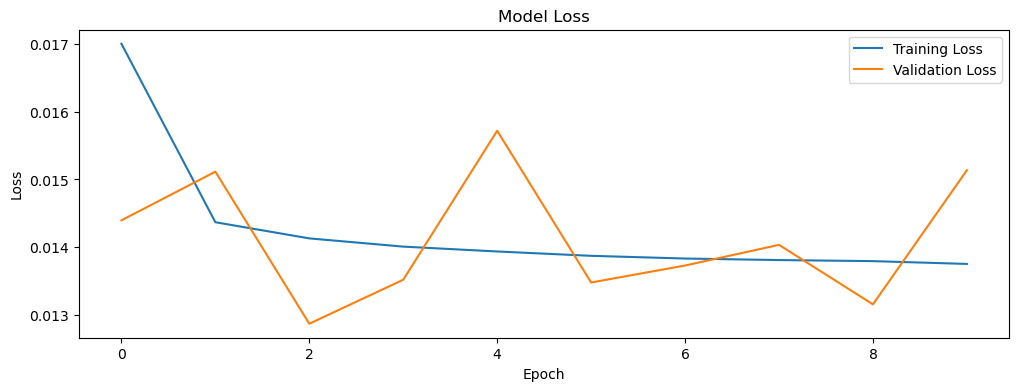

In [14]:
# Evaluate the model
loss, accuracy = net.evaluate(x_validation_encoded_scal, y_validation, verbose=1)  

# Make predictions
y_pred = net.predict(x_validation_encoded_scal)

print(f'Test Loss: {loss:.4f}')

# Plot loss

title = f"Adam, {loss_f}, {lr}, {Nhid1}, {Nhid2}, {Nhid3}, Bs {bs}, Epoch_{epochs}, Final loss_{loss:.4f}"

plt.figure(figsize=(12, 4))
plt.title(title)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
#plt.savefig(f'/Users/albam/Desktop/UNIVERSITAT/POSTGRAU/CAPSTONE_PROJECT/Gorrapiedra-proyecto/outputs/loss-ann/{title}.pdf')
print(title)
plt.show()

[[0.80605793]
 [0.88512087]
 [0.80550057]
 ...
 [0.84343076]
 [0.5128965 ]
 [0.71461666]]
2587132    0.716667
2649169    0.967456
1456720    0.950000
441495     0.307692
434253     0.195804
             ...   
2700220    0.832727
452751     0.466667
1873960    0.869565
1015308    0.404040
758037     0.643056
Name: percentage_docks_available, Length: 982548, dtype: float64


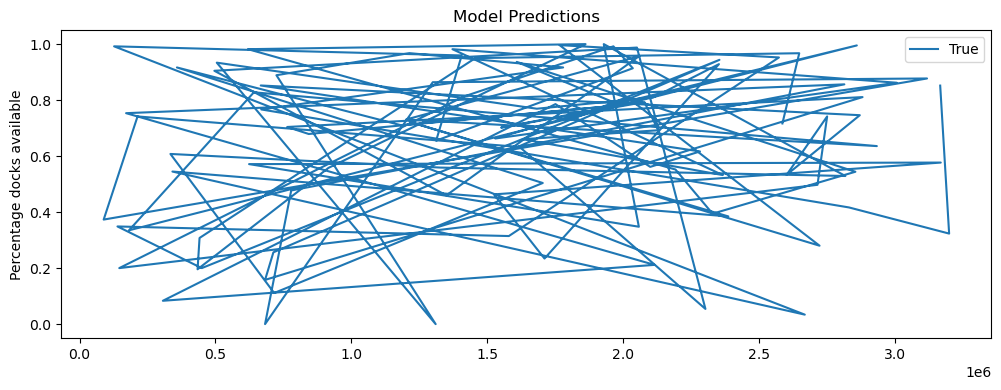

In [26]:
print(y_pred)
print(y_validation)

plt.figure(figsize=(12, 4))
plt.plot(y_validation[:100], label='True')
#plt.plot(y_pred[:100], label='Predicted')
plt.title('Model Predictions')
plt.ylabel('Percentage docks available')
plt.legend(loc='upper right')
plt.show()


# Simple neural network 

import torch 
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self, Nin, Nhid1, Nout):
        super(NeuralNetwork, self).__init__()

        # Define linear transformations and activation functions
        self.actfun = nn.LeakyReLU()

        self.lc1 = nn.Linear(Nin, Nhid1, bias=True)

        self.lc2 = nn.Linear(Nhid1, Nout, bias=True)

    def forward(self, x):
        o = self.lc2(self.actfun(self.lc1(x)))
        return o

# Hardware
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# Hiperparàmetres generals de la xarxa

Nin = x_train_encoded_scal.shape[1] # nombre d'inputs
Nout = 1 # nombre d'outputs
lr = 0.1 #learning rate
epochs = 30 # nombre d'iteracions

# Parametres de la xarxa    
Nhid1 = 5

# Creem la xarxa
model = NeuralNetwork(Nin=Nin, Nhid1=Nhid1,  Nout=Nout)

# Optimitzador
optimizer = torch.optim.Rprop(params=model.parameters(), lr=lr)
#optimizer = torch.optim.Adam(params=model.to(device).parameters(), lr=lr)
loss_fn = nn.MSELoss()
#loss_fn = nn.SmoothL1Loss() # L1 loss

net = model.to(device) # instanciem l'objecte

print('NN architecture: \n', net)
print("Layers and parameters:\n")
for name, param in net.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:50]} \n")


print(f"x_train_encoded_scal shape: {x_train_encoded_scal.shape}, dtype: {x_train_encoded_scal.dtype}")
print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")
print(f"x_validation_encoded_scal shape: {x_validation_encoded_scal.shape}, dtype: {x_validation_encoded_scal.dtype}")
print(f"y_validation shape: {y_validation.shape}, dtype: {y_validation.dtype}")

import psutil

def get_memory_usage():
    mem = psutil.virtual_memory()
    total_memory = mem.total / (1024 ** 3)  # Convert bytes to GB
    available_memory = mem.available / (1024 ** 3)  # Convert bytes to GB
    used_memory = total_memory - available_memory
    percent_used = (used_memory / total_memory) * 100
    return available_memory, used_memory, percent_used

available_memory, used_memory, percent_used = get_memory_usage()
print(f"Available memory: {available_memory:.2f} GB")
print(f"Used memory: {used_memory:.2f} GB")
print(f"Percentage used: {percent_used:.2f}%")

loss_list_tr = []
loss_list_val = []
print("hello")

try:
    print("Converting and moving training data...")
    train_set = torch.tensor(x_train_encoded_scal.reshape(-1,1), dtype=torch.float32).detach().to(device)
    print("Train set loaded successfully")
    
    target = torch.tensor(y_train, dtype=torch.float32).squeeze().detach().to(device)
    print("Target loaded successfully")
    
    validation_set = torch.tensor(x_validation_encoded_scal.reshape(-1,1), dtype=torch.float32).detach().to(device)
    print("Validation set loaded successfully")
    
    validation = torch.tensor(y_validation, dtype=torch.float32).squeeze().detach().to(device)
    print("Validation target loaded successfully")
except RuntimeError as e:
    print("RuntimeError:", e)
except Exception as e:
    print("Exception:", e)


from torch.utils.data import  DataLoader

batch_size = 64
# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
target_loader_train = DataLoader(target, batch_size=batch_size, shuffle=True)
target_loader_val = DataLoader(validation, batch_size=batch_size, shuffle=False)

r_training = trange(epochs, desc="Training", leave=True, colour="blue")
for t in r_training:
    print(t)

    model.train(True)
    optimizer.zero_grad()
    pred = net(train_set).squeeze()  # predicció
    loss = loss_fn(pred, target)  # càlcul del cost
    loss_list_tr.append(loss.item())

    net.eval()
    with torch.no_grad():
        val = net(validation_set).squeeze()
    loss_v = loss_fn(val, validation)  # càlcul del cost
    loss_list_val.append(loss_v.item())

    net.train()

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Plots
    if t%10 == 0 or t == epochs - 1: # or (t + 1) % 200 == 0 or t == epochs - 1:
        plt.plot(loss_list_tr, label='Training loss')
        plt.plot(loss_list_val, label='Validation loss')
        plt.legend()
        plt.show()
    r_training.set_postfix_str("L1: %6.4f" % (loss.item()))

r_training.close()